In [1]:


# !pip install shap
# !pip install opencv-python
# !pip install swig
# !pip install Box2D


# # !pip install box2d pygame


# !pip install gym
# !pip install pyglet==1.5.27
# !pip install stable-baseline3
# !pip install "gymnasium[all]"

# !pip install stable_baselines3

## FOR LOCAL Jupyter notebook
# !pip install tensorflow
# !pip install torch
# !pip install pygame
# !pip install tensorboard


In [2]:
import numpy as np
import imageio
import os
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
import gymnasium  as gym
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
import scipy.stats as stats
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import tensorflow as tf
import torch

2024-03-24 13:52:11.920222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 13:52:12.583004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# seeds
# Set seed for numpy
np.random.seed(100)

# Set seed for Python random module
import random
random.seed(100)

# Set seed for TensorFlow
tf.random.set_seed(100)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if tf.test.gpu_device_name():
    print('Default GPU Device:', tf.test.gpu_device_name())
else:
    print("GPU not found. Please ensure that GPU is enabled in Colab.")
    
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Device: cpu
GPU not found. Please ensure that GPU is enabled in Colab.
Num GPUs Available:  0


2024-03-24 13:52:14.680558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<h1> Important Libraries To Install </h1>

<h1> Parameter & Environment Information </h1>

<p>
    This environment is part of the Box2D environments.
</p>

<ul>
    <li> Action Space Discrete(4) </li>
    <li> Observation Shape (8,) </li>
    <li> Observation High [1.5 1.5 5. 5. 3.14 5. 1. 1. ] </li>
    <li> Observation Low [-1.5 -1.5 -5. -5. -3.14 -5. -0. -0. ] </li>
    <li> Import gymnasium.make("LunarLander-v2") </li>
</ul>

<h3> Description </h3>
<p>This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.</p>

<h3> Action Space </h3>
<p>
There are four discrete actions available:

* 0: do nothing
* 1: fire left orientation engine
* 2: fire main engine
* 3: fire right orientation engine

</p>

<h3> Observation Space </h3>
<p>
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.
</p>

<h3> Reward </h3>
<p>
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

* is increased/decreased the closer/further the lander is to the landing pad.
* is increased/decreased the slower/faster the lander is moving.
* is decreased the more the lander is tilted (angle not horizontal).
* is increased by 10 points for each leg that is in contact with the ground.
* is decreased by 0.03 points each frame a side engine is firing.
* is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.
</p>

<h3> Starting State </h3>

<p>The lander starts at the top center of the viewport with a random initial force applied to its center of mass.</p>

<h3> Episode Termination </h3>
<p> The episode finishes if:<br>
    
1. the lander crashes (the lander body gets in contact with the moon);<br>
2. the lander gets outside of the viewport (x coordinate is greater than 1);<br>
3. the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:<br>

When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. If a body is awake and collides with a sleeping body, then the sleeping body wakes up. Bodies will also wake up if a joint or contact attached to them is destroyed.
</p>

In [4]:
env = gym.make("LunarLander-v2", render_mode="human")

In [5]:
print("The Action inter is descrete {}".format(env.action_space.n))
print("Shape of Observation is {}".format(env.observation_space.sample().shape))

The Action inter is descrete 4
Shape of Observation is (8,)


<h1> Baseline Model. </h1>

In [6]:
rewards = []
obs = env.reset()
done = False
MAX_RUN = 10

for i in range(MAX_RUN):
    while not done:
        env.render()
        action_sample = env.action_space.sample()
        # let's take a step in the environment
        obs, rwd, done, info ,_  = env.step(action_sample)
        rewards.append(rwd)
env.close()
print("Mean Reward after {} max run is {}".format(MAX_RUN, np.mean(np.array(rewards))))

Mean Reward after 10 max run is -1.3004164000428067


<h1> Reinforcement Learning For Training The Model </h1>

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [8]:
train_from_file = False
# Hyperparameters are from RL_Zoo
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/a2c.yml
policy = "MlpPolicy"
n_steps = 5
learning_rate = 0.00083
# batch_size = 256
# n_epochs = 10
n_envs = 8
n_timesteps = 8e6
gamma = 0.995
ent_coef = 0.00001

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir="log_dir_A2C/")

# env
env = make_vec_env("LunarLander-v2", n_envs=n_envs, monitor_dir="log_dir_A2C/")

# instantiate the agent
if train_from_file:
  model = A2C.load(path="log_dir_A2C/best_model.zip", env=env)
else:
  model = A2C(policy, env, learning_rate = learning_rate, n_steps = n_steps, ent_coef= ent_coef, tensorboard_log="./TensorBoardLog/", verbose=1)

# train the agent
model.learn(total_timesteps=n_timesteps, callback=callback)

Using cpu device
Logging to ./TensorBoardLog/A2C_7
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 103      |
|    ep_rew_mean        | -325     |
| time/                 |          |
|    fps                | 2942     |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -1.3     |
|    explained_variance | 0.0488   |
|    learning_rate      | 0.00083  |
|    n_updates          | 99       |
|    policy_loss        | -8.36    |
|    value_loss         | 91.2     |
------------------------------------
Num timesteps: 8000
Best mean reward: -inf - Last mean reward per episode: -260.29
Saving new best model to log_dir_A2C/best_model.zip
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 112      |
|    ep_rew_mean        | -260     |
| time/                 |          |


# Plotting

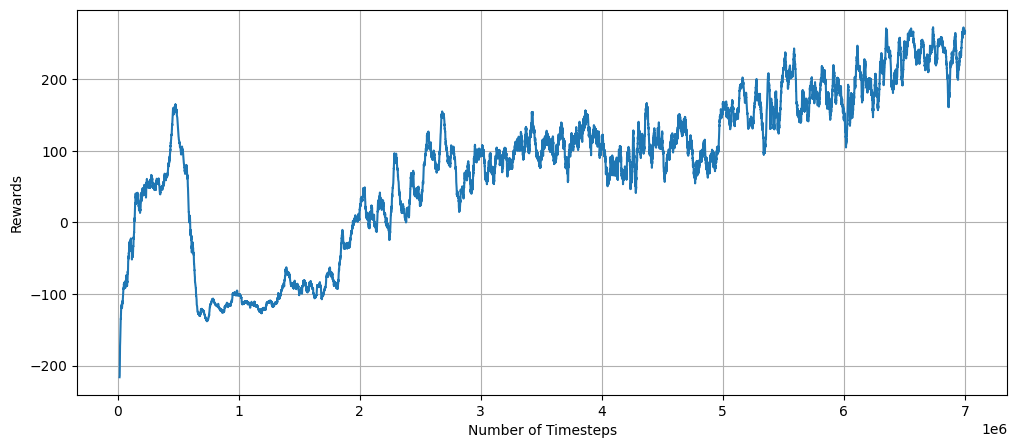

In [14]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """

    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]
    fig = plt.figure(title, figsize=(12,5))
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    # plt.title(title + " Smoothed A2C after 8000,000 Timesteps")
    plt.grid()
    plt.show()

plot_results("log_dir_A2C")

# Evaluation

In [15]:
env = make_vec_env("LunarLander-v2", n_envs=1,monitor_dir="evaluate_log_dir_A2C")

In [16]:
model = A2C.load(path="log_dir_A2C/best_model.zip")

#### Stable Baseline 3 Evaluation Function.

In [17]:
mean_reward, std_reward = evaluate_policy(model, env,n_eval_episodes=10, render=True, deterministic=True)
print("Mean & Std Reward after {} max run is {} & {}".format(10,mean_reward, std_reward))

Mean & Std Reward after 10 max run is 277.8031373 & 22.651884249193934


# GIF of a Train Agent

In [13]:
env = make_vec_env("LunarLander-v2", n_envs=1)
model = A2C.load(path="log_dir_A2C/best_model.zip")

images = []
obs = env.reset()
img = env.render(mode="rgb_array")
for i in range(1000):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = env.step(action)
    img = env.render(mode="rgb_array")

imageio.mimsave("lunar lander_A2C.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
